In [1]:
# <market price 데이터셋의 기본 정보 구하기>

%matplotlib inline 
# 주피터 노트북을 실행한 브라우저 내부에서 바로 그림을 볼 수 있게끔 만드는 것

import pandas as pd # 판다스 라이브러리 import
import numpy as np # 넘파이 라이브러리 import
import matplotlib.pyplot as plt # matplot 라이브러리 import

import warnings
warnings.filterwarnings("ignore")

file_path = '../data/market-price.csv' # 사용할 파일의 경로 file_path 변수에 저장
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price']) 
# pandas로 csv파일을 dataframe으로 변환, 헤더 이름을 day와 price로 지정

print(bitcoin_df.shape) # 주어진 행렬 크기를 shape함수를 사용하여 출력
print(bitcoin_df.info()) # info 함수 사용하여, 데이터의 기초적인 정보 출력
bitcoin_df.tail() # tail함수 사용하여 데이터셋의 하위 행 출력 (디폴트 값: 5)

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


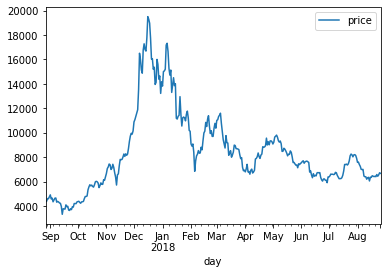

In [2]:
# <시계열 정보를 데이터 프레임의 index로 설정하여 가격의 추이를 시각화하기>

# to_datetime으로 day 피처를 시계열 피처로 변환합니다.
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day']) # to_datetime으로 object형식인 day를 timestamp형태로 변환(시간으로 인식)

# day 데이터 프레임의 index로 설정합니다.
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace = True) # df의 하나의 열로 인덱스 지정. day로 index 지정 (day를 열로)
# False가 기본값. inplace = True라고 쓰면 데이터가 바로 변경되며 업데이트되었다는 것을 뜻한다.

# 일자별 비트코인 시세를 시각화합니다.
bitcoin_df.plot() # column이 여러개인 데이터. 한 그래프에 모두 그려짐
plt.show() # 그래프 그리기

In [3]:
# <ARIMA 모델 활용하기: 모델 학습>

# statsmodel 모듈로 ARIMA 분석 수행
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR = 2, 차분 = 1, MA = 2) 파라미터로 ARIMA 모델을 학습합니다.
# AR이 몇 번째 과거까지를 바라보는지에 대한 파라미터
# 차분에 대한 파라미터
# MA가 몇 번째 과거까지를 바라보는지에 대한 파라미터
model = ARIMA(bitcoin_df.price.values, order = (2,1,2))
#trend : constant를 가지고 있는지, c - constant / nc - no constant
#disp : 수렴 정보를 나타냄
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Mon, 23 May 2022   AIC                           5587.107
Time:                        02:42:16   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3827     27.794      0.230      0.818     -48.092      60.858
ar.L1.D.y     -0.3785      1.822     -0.208      0.835      -3.949       3.192
ar.L2.D.y      0.1588      1.187      0.134      0.8

<AxesSubplot:>

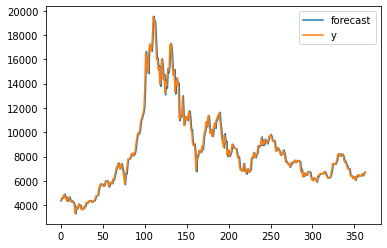

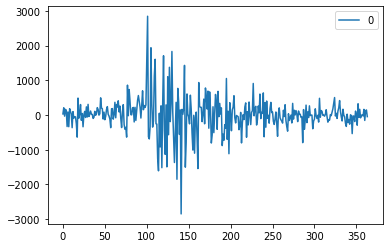

In [4]:
# <ARIMA 모델 활용하기: 모델의 성능 & 예측 결과 시각화>

# 학습 데이터에 대한 예측 결과입니다.(첫 번째 그래프)
# plot_predict()함수로 학습한 모델에 학습 데이터셋을 넣었을 때의 시계열 에측결과의 시각화 자동 수행 가능
fig = model_fit.plot_predict() 
# 잔차의 변동을 시각화합니다. (두 번째 그래프)
# 실제값과 예측값 사이의 오차 변동 나타냄 (폭이 일정할수록 좋은 예측 모델을 학습시킨 것)
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [5]:
# <ARIMA 모델 활용하기: 실제 데이터와의 비교>

forecast_data = model_fit.forecast(steps = 5) # 학습 데이터셋으로부터 5일 뒤를 예측

forecast_df = pd.DataFrame(forecast_data)
forecast_df.head()
# 예측값, stderr, upper bound, lower bound 순으로 결과 나옴
# 표준 오차(StdErr)는 계산된 평균의 표준 편차

,0,1,2,3,4
0,6676.944523,6685.106873,6690.385374,6697.46855,6703.410821
1,512.415298,753.505059,914.97814,1061.452357,1184.436724
2,"[5672.628994864229, 7681.260051940083]","[5208.26409527599, 8161.94965115615]","[4897.0611726856805, 8483.70957437147]","[4617.060158046408, 8777.876941723815]","[4381.95749864014, 9024.864142554728]"


In [6]:
# <ARIMA 모델 활용하기: 실제 데이터와의 비교>

forecast_data = model_fit.forecast(steps = 5) # 학습 데이터셋으로부터 5일 뒤를 예측

# 테스트 데이터셋을 불러옴
test_file_path = '../data/market-price-test.csv' # 사용할 파일 경로 저장
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y']) # csv파일을 dataframe으로 변환

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다.(2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터 입니다.(2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]: # 5월의 예측 데이터인 forecast_data의 lowerbound와 upperbound를 하나씩 반복문 이용해서 불러옴
    lower = lower_upper[0] # 첫 번째 값은 lowerbound를 가리킴
    upper = lower_upper[1] # 두 번째 값은 upperbound를 가리킴
    pred_y_lower.append(lower) # 이전에 만들어 둔 pred_y_lower 리스트에 값 추가
    pred_y_upper.append(upper) # 이전에 만들어 둔 pred_y_upper 리스트에 값 추가

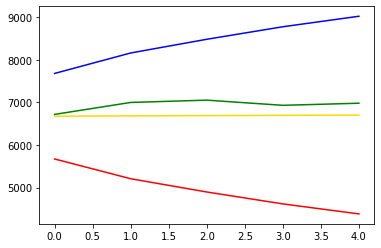

In [7]:
plt.plot(pred_y, color = "gold") # 예측한 가격
plt.plot(pred_y_lower, color = "red") # 예측한 최저 가격 그래프
plt.plot(pred_y_upper, color = "blue") # 예측한 최고 가격 그래프
plt.plot(test_y, color = "green") # 실제 가격 그래프

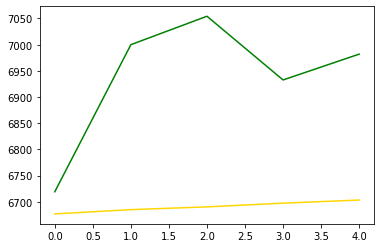

In [8]:
plt.plot(pred_y, color = "gold") # 예측한 가격
plt.plot(test_y, color = "green") # 실제 가격

In [10]:
# Facebook Prophet 활용하기

from fbprophet import Prophet # fbprophet 라이브러리를 사용하기 위해 Prophet이라는 클래서 선언

bitcoin_df = pd.read_csv(file_path, names = ['ds','y']) # 데이터 프레임 피쳐를 ds와 y로 변경하여 csv파일을 dataframe으로 변환
# seasonality_mode : 연간, 월간, 주간, 일간 등의 트랜드성을 반영하는 것을 의미하는 파라미터
prophet = Prophet(seasonality_mode = 'multiplicative'),\
            yearly_seasonality = True,\ # 주기성이 연단위를 나타내는 파라미터
            weekly_seasonality = True, daily_seasonality = True,\ # 주기성이 주, 일 단위를 나타내는 파라미터
            changepoint_prior_scale = 0.5) 
# changepoint_prior_scale : 트랜드가 변경되는 문맥을 반영하는 파라미터, 수치가 높을수록 모델은 과적합에 가까워짐
prophet.fit(bitcoin_df) # bitcoin_df을 해당 prophet 모델에 학습시킴

SyntaxError: cannot assign to function call (Temp/ipykernel_3640/2261222830.py, line 7)

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.4.0-py3-none-any.whl (13 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached holidays-0.13-py3-none-any.whl (172 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached pysimdjson-3.2.0-cp39-cp39-win_amd64.whl (157 kB)
  Using cached pystan-3.3.0-py3-none-any.whl (13 kB)
  Using cached aiohttp-3.8.1-cp39-cp39-win_amd64.whl (554 kB)
  Using cached pystan-3.2.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.1.1-py3-none-any.whl (13 kB)
  Using cached pystan-3.1.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.0.2-py3-none-any.whl (13 kB)
  Using cached pystan-3.0.1-py3-none-any.whl (12 kB)
  Using cached pystan-3.0.0-py3-none-any.whl (12 kB)
  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Running setup.py clean for fbprophet
  Created wheel for pystan: filename=pystan-2.19.1.1-cp39-cp39-win_amd64.whl size=28

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\User\miniconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\User\\AppData\\Local\\Temp\\pip-install-z3qlh3mg\\fbprophet_72d75da7225242d9862d1ce6a1d92782\\setup.py'"'"'; __file__='"'"'C:\\Users\\User\\AppData\\Local\\Temp\\pip-install-z3qlh3mg\\fbprophet_72d75da7225242d9862d1ce6a1d92782\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\User\AppData\Local\Temp\pip-wheel-868pplh7'
       cwd: C:\Users\User\AppData\Local\Temp\pip-install-z3qlh3mg\fbprophet_72d75da7225242d9862d1ce6a1d92782\
  Complete output (44 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\

In [ ]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods = 5, freq = 'd')
forecast_data = prophet.predict(future_data) # 예측 값을 forecast_data에 저장
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5) # 각 결과 값 출력

In [ ]:
fig1 = prophet.plot(forecast_data) # fbprophet 모델의 학습 결과를 시각화한 결과
# 그래프의 검은 점은 실제가격, 파란 선은 예측 가격

In [ ]:
fig2 = prophet.plot_components(forecast_data) # fbprophet에서 제공하는 트렌드 정보 시각화 그래프
# seasonality_mode 파라미터를 앞서 설정해놓은 경우에만 이 시각화 가능
# 전체적인 데이터의 트렌드 / year, weekly, daily 순의 트렌드 확인 가능

In [ ]:
# <Facebook Prophet 활용하기: 실제 데이터와의 비교>

bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 예측 데이터의 최대값입니다.

plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [ ]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [ ]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

In [ ]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

# 상한가를 설정합니다.
bitcoin_df['cap'] = 20000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정합니다.
prophet = Prophet(seasonality_mode='multiplicative', 
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정합니다.
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

In [ ]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [ ]:
# 18000 이상의 데이터는 이상치라고 판단
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

# prophet 모델을 학습합니다.
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력합니다.
fig = prophet.plot(forecast_data)

In [ ]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)